# COGS 108 - Final Project 

# Overview

My project intends to identify the relationship between amount of different amenities and review ratings of public parks, and between amount of different amenities and review count of public parks. My analysis revealed a negative correlation between both of the relationships. The correlation suggests that a higher amount of different amenities results in lower review ratings, while a higher amount of different amenities results in less review counts.

# Name & GitHub ID

- Name: Nathan James Basa
- GitHub Username: jamesbasa

# Research Question

What is the relationship between the amount of different amenities and the review ratings of public parks? What is the relationship between the amount of different amenities and the review count of public parks? This data analysis will focus on public parks in San Diego County.

## Background and Prior Work

There are over 340 parks overseen by San Diego Parks and Recreation, and each of them have their own unique facilities and amenities. My research question revolves around the relationship between favorability of San Diego public parks and park amenities, such as playgrounds or baseball fields. 

In order to become familiar with this corresponding topic, I researched articles that touch on the impact of amenities on public park perception and popularity. RAND Corporation's study of public parks found that "parks with walking loops had 80 percent more users compared to those without loops" (1). This stemmed from seniors using the parks more often and resulted in visitors engaging in more physical activity.

The benefits of certain facilities are detailed in another article on Community Tool Box's website. Good facilities "contribute to the general quality of life in the community...instill a sense of ownership and community pride in residents...[and] can help prevent crime and other antisocial behavior" (2). These benefits motivate my question of whether certain facilities indeed contribute to public park usage and popularity.


References (include links):
- 1) Cohen, Deborah A. and Kristin Leuschner. "How Can Neighborhood Parks Attract More Users?" https://www.nrpa.org/parks-recreation-magazine/2017/july/how-can-neighborhood-parks-attract-more-users/
- 2) Rabinowitz, Phil. Community Tool Box. https://ctb.ku.edu/en/table-of-contents/implement/physical-social-environment/parks-community-facilities/main

# Hypothesis


I hypothesize that the existence of a higher number of different amenities in parks correlates to higher park review ratings, while a lower number of different amenities in parks correlates to lower park review ratings. Additionally, I hypothesize that the existence of a higher number of different amenities in parks correlates to more park reviews, while a lower number of different amenities in parks correlates to less park reviews.

Reference 1's example of a walking loop increasing visitor turnout motivates my hypothesis due to it being a concrete example of an amenity being correlated to increased park popularity, and more amenities may increase the likelihood of visitors enjoying the park. The list of benefits that are provided by reference 2 for facilities contributing to positive social impact also motivate my hypothesis of certain amenities increasing park popularity.

# Dataset(s)

The following datasets were provided by the instructor for the purpose of the final project.

- Dataset Name: Yelp Data for San Diego Parks
- Link to the dataset: https://www.yelp.com/ (curated by Professor Ellis)
- Number of observations: 833
- Description: This dataset includes data about San Diego parks and their respective ratings. The variables available include (but are not limited to) park name, average rating, and amount of reviews.


- Dataset Name: Joint Use Parks Data
- Link to the dataset: https://data.sandiego.gov/datasets/joint-use/
- Number of observations: 96
- Description: This dataset includes data about San Diego joint use parks and their respective amenities. The variables available include (but are not limited to) park name, park amenity notes, and the amount of several distinct  amenities.


- Dataset Name: Rec Center Locations Data
- Link to the dataset: https://data.sandiego.gov/datasets/recreation-center-locations/
- Number of observations: 57
- Description: This dataset includes data about San Diego recreation centers and their respective amenities. The variables available include (but are not limited to) park name and the amount of several distinct  amenities.


These datasets contain my ideal data, which includes park names, different amenities, ratings, and review counts. In order to find out the ratings and number of different amenities per park, I will combine the Yelp, joint use, and recreation center park data based on the park names.

# Setup

In [1]:
#imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import seaborn as sns
sns.set()
sns.set_context('talk')

import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#default is 10; Set to None to display all rows/cols in dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Read in the 3 datasets that will later be cleaned and analyzed.

In [3]:
#read data
df_reviews = pd.read_csv('yelp_SD_parks.csv')
df_joint_use = gpd.read_file('joint_use_datasd.geojson')
df_rec_centers = gpd.read_file('rec_centers_datasd.geojson')

# Data Cleaning

Remove columns with information that I will not be using. For the reviews dataset, I drop the columns that do not pertain to the park name, rating, or review count. For the park datasets, I drop the columns that do not pertain to the park name or a park amenity.

In [4]:
df_reviews.drop(["address","phone","id","url","longitude","latitude","is_closed"], axis=1, inplace=True)
df_joint_use.drop(["objectid", "name", "school_dis", "city_acres", "dist_acres", "enhanced", "strt_date", "term_yrs", "exp_date", "address", "community", "council_di", "serv_dist", "playg_inst", "field_ligh", "geometry"], axis=1, inplace=True)
df_rec_centers.drop(["objectid", "rec_bldg", "address", "zip", "sq_ft", "year_built", "serv_dist", "current_cd", "fy13_cd", "facility_n", "thomas_bro", "community", "geometry"], axis=1, inplace=True)

#rename some parks to make them distinct from each other
df_rec_centers.set_value(14, 'park_name', 'Encanto Recreation Center')
df_rec_centers.set_value(15, 'park_name', 'Encanto Teen Center')
df_rec_centers.set_value(20, 'park_name', 'Black Mountain Multi-Purpose Gym')
df_rec_centers.set_value(38, 'park_name', 'Mission Bay Robb Field Rec Center')
df_rec_centers.set_value(45, 'park_name', 'Mission Bay Santa Clara Point Rec Center')
df_rec_centers.set_value(46, 'park_name', 'Balboa Park Municipal Gymnasium')
df_rec_centers.set_value(47, 'park_name', 'Balboa Park Golden Hills Rec Center')
df_rec_centers.set_value(48, 'park_name', 'Balboa Park Activity Center')

#combine two similar columns that pertain to baseball fields by using the max value
df_joint_use["baseball"] = df_joint_use[["baseb_50_6", "baseb_90"]].max(axis=1)
df_joint_use.drop(["baseb_50_6", "baseb_90"], axis=1, inplace=True)

In [5]:
df_reviews.head()

,name,rating,review_count
0,Balboa Park,5.0,2105
1,Civita Park,4.5,46
2,Waterfront Park,4.5,242
3,Trolley Barn Park,4.5,102
4,Bay View Park,5.0,42


In [6]:
df_joint_use.head()

,facility,notes,playground,tot_lot,softball,multi_purp,basketball,tennis_ct,sand_vball,comfort_st,concess_st,baseball
0,Adams Avenue Community Park,"Lighted, turfed play field",1,0,1,1,0,0,0,0,0,0
1,Alcott Elementary,"Turfed play field, tot lot, passive turf area",1,1,1,1,0,0,0,0,0,0
2,Bayview Terrace Elementary,Turfed play fields,1,0,1,1,1,0,0,0,0,1
3,Bird Rock Neighborhood Park,Turfed play field and hard courts,1,0,1,1,1,0,0,0,0,0
4,Black Mountain Middle,Gymnasium and parking lot,0,0,0,0,0,0,0,0,0,0


In [7]:
df_rec_centers.head()

,park_name,adult_ctr,comfort_st,comp_rm,dance_rm,game_rm,gymnasium,kiln,kiln_rm,kitchen,multp_rm,racqb_ct,stage,teen_ctr,tinytot_rm,weight_rm
0,Scripps Ranch Community Park,0,0,0,0,0,1,0,0,1,2,0,0,0,0,0
1,North Park Community Park,1,0,0,1,1,1,1,1,1,3,0,0,1,1,0
2,Southcrest Community Park,0,0,0,0,1,1,1,0,1,2,0,0,1,0,1
3,Azalea Neighborhood Park,0,0,1,0,0,0,2,1,1,1,0,0,0,0,0
4,Colina Del Sol Community Park,0,0,0,0,1,1,1,1,1,2,0,0,0,0,0


One column in the joint use park dataset includes textual information about additional amenities. Here I create a function that interprets this data.

In [8]:
def find_specified_amenity(string, amenity):
    
    string = string.lower()
    string = string.strip()
    
    if amenity in string:
        output = 1
    else:
        output = 0
    
    return output

Then create a new column for each unique amenity found in the previously mentioned textual information column (that is not repetitive of the other columns in either park dataset) and remove the previously mentioned column.

In [9]:
df_joint_use['gymnasium'] = df_joint_use['notes'].apply(find_specified_amenity, amenity='gymnasium')
df_joint_use['turfed field'] = df_joint_use['notes'].apply(find_specified_amenity, amenity='turfed play field')
df_joint_use['track'] = df_joint_use['notes'].apply(find_specified_amenity, amenity='track')
df_joint_use['picnic pavilion'] = df_joint_use['notes'].apply(find_specified_amenity, amenity='picnic')
df_joint_use['swimming pool'] = df_joint_use['notes'].apply(find_specified_amenity, amenity='pool')

df_joint_use.drop(["notes"], axis=1, inplace=True)

Rename the columns for an easier merge, then merge the two park datasets.

In [10]:
#rename columns to allow for merge
df_joint_use.rename(columns={'facility':'park_name'}, inplace=True)
df_rec_centers.rename(columns={'multp_rm':'multi_purp'}, inplace=True)

#merge datasets based on the park name
df_parks = pd.merge(df_joint_use, df_rec_centers, how='outer', on=['park_name'])
df_parks = df_parks.fillna(0)
df_parks.set_index('park_name', inplace=True)

df_parks.head()

,playground,tot_lot,softball,multi_purp_x,basketball,tennis_ct,sand_vball,comfort_st_x,concess_st,baseball,gymnasium_x,turfed field,track,picnic pavilion,swimming pool,adult_ctr,comfort_st_y,comp_rm,dance_rm,game_rm,gymnasium_y,kiln,kiln_rm,kitchen,multi_purp_y,racqb_ct,stage,teen_ctr,tinytot_rm,weight_rm
park_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams Avenue Community Park,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
Alcott Elementary,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bayview Terrace Elementary,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bird Rock Neighborhood Park,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Black Mountain Middle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are now three duplicate columns, denoted by '_x' and '_y' due to overlaps in values. For every row, I will use the maximum of the two columns. A few parks have a positive value in both of the shared duplicate columns due to some  being found in both of the park datasets before merge, but I will still take the maximum value. (This should not affect the results, since the analysis only depends on number of unique amenities and not total number of amenities. If the duplicate columns both have positive values for the same park, it means they *do* have this amenity, and that is the focus of the research questions.)

In [11]:
#take the max of each duplicate pair of columns and put it in a new column
df_parks["comfort_st"] = df_parks[["comfort_st_x", "comfort_st_y"]].max(axis=1)
df_parks["gymnasium"] = df_parks[["gymnasium_x", "gymnasium_y"]].max(axis=1)
df_parks["multi_purp"] = df_parks[["multi_purp_x", "multi_purp_y"]].max(axis=1)

#drop the unneeded duplicate pairs of columns
df_parks.drop(["comfort_st_x", "comfort_st_y"], axis=1, inplace=True)
df_parks.drop(["gymnasium_x", "gymnasium_y"], axis=1, inplace=True)
df_parks.drop(["multi_purp_x", "multi_purp_y"], axis=1, inplace=True)

df_parks.head()

,playground,tot_lot,softball,basketball,tennis_ct,sand_vball,concess_st,baseball,turfed field,track,picnic pavilion,swimming pool,adult_ctr,comp_rm,dance_rm,game_rm,kiln,kiln_rm,kitchen,racqb_ct,stage,teen_ctr,tinytot_rm,weight_rm,comfort_st,gymnasium,multi_purp
park_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams Avenue Community Park,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Alcott Elementary,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Bayview Terrace Elementary,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Bird Rock Neighborhood Park,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Black Mountain Middle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Calculate number of different amenities for each park.

In [12]:
#get # of non-zero columns per park/row
df_parks['number of different amenities'] = df_parks.astype(bool).sum(axis=1)

Remove amenity columns with information that will not be needed anymore and prepare for a merge with the Yelp dataset.

In [13]:
df_parks.drop(["playground","tot_lot","softball","basketball","tennis_ct","sand_vball","concess_st","baseball","turfed field","track","picnic pavilion","swimming pool","adult_ctr","comp_rm","dance_rm","game_rm","kiln","kiln_rm","kitchen","racqb_ct","stage","teen_ctr","tinytot_rm","weight_rm","comfort_st","gymnasium","multi_purp"], axis=1, inplace=True)

df_parks.head()

,number of different amenities
park_name,
Adams Avenue Community Park,9
Alcott Elementary,5
Bayview Terrace Elementary,6
Bird Rock Neighborhood Park,5
Black Mountain Middle,1


Rename the park name column of the Yelp review dataset for an easier merge, then rename parks to match between datasets.

In [14]:
df_reviews.rename(columns={'name':'park_name'}, inplace=True)

df_reviews['park_name'].replace(to_replace='Adams Avenue Recreation Center', value='Adams Avenue Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Bay View Park', value='Bayview Terrace Elementary', inplace=True)
df_reviews['park_name'].replace(to_replace='Bird Rock', value='Bird Rock Neighborhood Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Black Mountain Open Space Park', value='Black Mountain Middle', inplace=True)
df_reviews['park_name'].replace(to_replace='Clay Park', value='Clay Elementary', inplace=True)
df_reviews['park_name'].replace(to_replace='Crown Point', value='Crown Point Elementary', inplace=True)
df_reviews['park_name'].replace(to_replace='Jerabek Park', value='Jerabek Elementary', inplace=True)
df_reviews['park_name'].replace(to_replace='Scripps Ranch Recreation Center', value='Scripps Ranch Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Normal Heights', value='Normal Heights Elementary', inplace=True)
df_reviews['park_name'].replace(to_replace='Sage Canyon Elementary School', value='Sage Canyon Neighborhood Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Carmel Creek Park', value='Carmel Creek Neighborhood Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Spring Canyon Park', value='Spring Canyon Neighborhood Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Ocean Air Recreation Center', value='Ocean Air Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Ocean View Hills Neighborhood Park', value='Ocean View Hills K8', inplace=True)
df_reviews['park_name'].replace(to_replace='Ashley Falls Neighborhood Park', value='Ashley Falls Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Linda Vista Community Park', value='Linda Vista Elementary', inplace=True)
df_reviews['park_name'].replace(to_replace=['Solana Highlands Park','Solana Highlands Elementary School'], value='Solana Highlands', inplace=True)
df_reviews['park_name'].replace(to_replace='Azalea Park and Recreation Center', value='Azalea Neighborhood Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Colina Del Sol Park & Rec Center', value='Colina Del Sol Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Serra Mesa Recreation Center', value='Serra Mesa Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Rancho Bernardo Community Park', value='Rancho Bernardo Dog Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Mountain View Community Center', value='Mountain View Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Lopez Ridge Park and Meeting Center', value='Lopez Ridge Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Hilltop Park and Recreation Center', value='Hilltop Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Pacific Beach Recreation Center', value='Pacific Beach Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Carmel Valley Recreation Center', value='Carmel Valley TownCenter Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Allied Gardens Recreational Center', value='Allied Gardens Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace=['San Carlos Park','San Carlos Recreation Center'], value='San Carlos Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Standley Recreation Center', value='Standley Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Nobel Athletic Fields & Recreation Center', value='Nobel Athletic Area', inplace=True)
df_reviews['park_name'].replace(to_replace='Robert Egger, Sr. - South Bay Recreation Center', value='Robert Egger, Sr. - South Bay Community Par', inplace=True)
df_reviews['park_name'].replace(to_replace='Presidio Park', value='Presidio Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Carmel Mountain Ranch Community Park', value='Carmel Mtn Ranch / Sabre Springs Comm Park', inplace=True)
df_reviews['park_name'].replace(to_replace=['Ocean Beach Park'], value='Ocean Beach Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace=['Kearny Mesa Park & Recreation Center','Kearny Mesa Park'], value='Kearny Mesa Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Tierrasanta Community Park and Recreation Center', value='Tierrasanta Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='South Clairemont Recreation Center & Community Park', value='South Clairmont Community Park', inplace=True)
df_reviews['park_name'].replace(to_replace='Montgomery-Waller Park', value='Montgomery-Waller Community Park', inplace=True)

In [15]:
df_reviews.sort_values('park_name', inplace=True)
df_reviews = df_reviews.reset_index(drop=True)
df_reviews.set_index('park_name', inplace=True)

df_reviews.head()

,rating,review_count
park_name,,
13th & Market,3.5,85
1935 Cactus Garden,5.0,1
4S Patriot Park,4.5,16
4S Ranch Community Park,5.0,17
5 Star Dealer School,5.0,1


Merge the Yelp and park datasets based on park name.

In [36]:
df_all = pd.merge(df_reviews, df_parks, how='inner', on=['park_name'])
df_all.reset_index(inplace=True)

#clean up column names for readability
df_all.rename(columns={'park_name':'park name'}, inplace=True)
df_all.rename(columns={'review_count':'review count'}, inplace=True)

df_all.head()

,park name,rating,review count,number of different amenities
0,Adams Avenue Community Park,3.5,4,9
1,Allied Gardens Community Park,3.0,5,6
2,Allied Gardens Community Park,4.5,18,6
3,Azalea Neighborhood Park,4.0,2,5
4,Bayview Terrace Elementary,5.0,42,6


There are several duplicate park rows due to similar naming conventions (e.g. "park" and "park & recreation center"). Combine the ratings and review counts of these duplicates.

In [17]:
#combine duplicate park rows by taking the average of the ratings weighted by the review counts and taking the sum of the review counts
df_all.set_value(1, 'rating', (((df_all.ix[1, 'rating']*df_all.ix[1, 'review count'])+(df_all.ix[2, 'rating']*df_all.ix[2, 'review count']))/(df_all.ix[1, 'review count']+df_all.ix[2, 'review count'])))
df_all.set_value(1, 'review count', df_all.ix[1, 'review count']+df_all.ix[2, 'review count'])

df_all.set_value(18, 'rating', (((df_all.ix[18, 'rating']*df_all.ix[18, 'review count'])+(df_all.ix[19, 'rating']*df_all.ix[19, 'review count']))/(df_all.ix[18, 'review count']+df_all.ix[19, 'review count'])))
df_all.set_value(18, 'review count', df_all.ix[18, 'review count']+df_all.ix[19, 'review count'])

df_all.set_value(24, 'rating', (((df_all.ix[24, 'rating']*df_all.ix[24, 'review count'])+(df_all.ix[25, 'rating']*df_all.ix[25, 'review count']))/(df_all.ix[24, 'review count']+df_all.ix[25, 'review count'])))
df_all.set_value(24, 'review count', df_all.ix[24, 'review count']+df_all.ix[25, 'review count'])

df_all.set_value(36, 'rating', (((df_all.ix[36, 'rating']*df_all.ix[36, 'review count'])+(df_all.ix[37, 'rating']*df_all.ix[37, 'review count']))/(df_all.ix[36, 'review count']+df_all.ix[37, 'review count'])))
df_all.set_value(36, 'review count', df_all.ix[36, 'review count']+df_all.ix[37, 'review count'])

#remove the unneeded duplicate park rows
df_all.drop([df_all.index[2], df_all.index[19], df_all.index[25], df_all.index[37]], inplace=True)

#dataset is now ready for analysis
df_all.set_index('park_name', inplace=True)
df_all.head()

,rating,review count,number of different amenities
park_name,,,
Adams Avenue Community Park,3.500000,4,9
Allied Gardens Community Park,4.173913,23,6
Azalea Neighborhood Park,4.000000,2,5
Bayview Terrace Elementary,5.000000,42,6
Bird Rock Neighborhood Park,4.500000,19,5


# Data Analysis & Results

Take a look at some of the data statistics to get a better understanding.

In [18]:
df_all.describe()

,rating,review count,number of different amenities
count,41.000000,41.000000,41.000000
mean,3.972678,20.219512,4.512195
std,0.587197,21.307877,2.471052
min,3.000000,1.000000,1.000000
25%,3.500000,6.000000,3.000000
50%,4.000000,15.000000,4.000000
75%,4.500000,23.000000,5.000000
max,5.000000,85.000000,14.000000


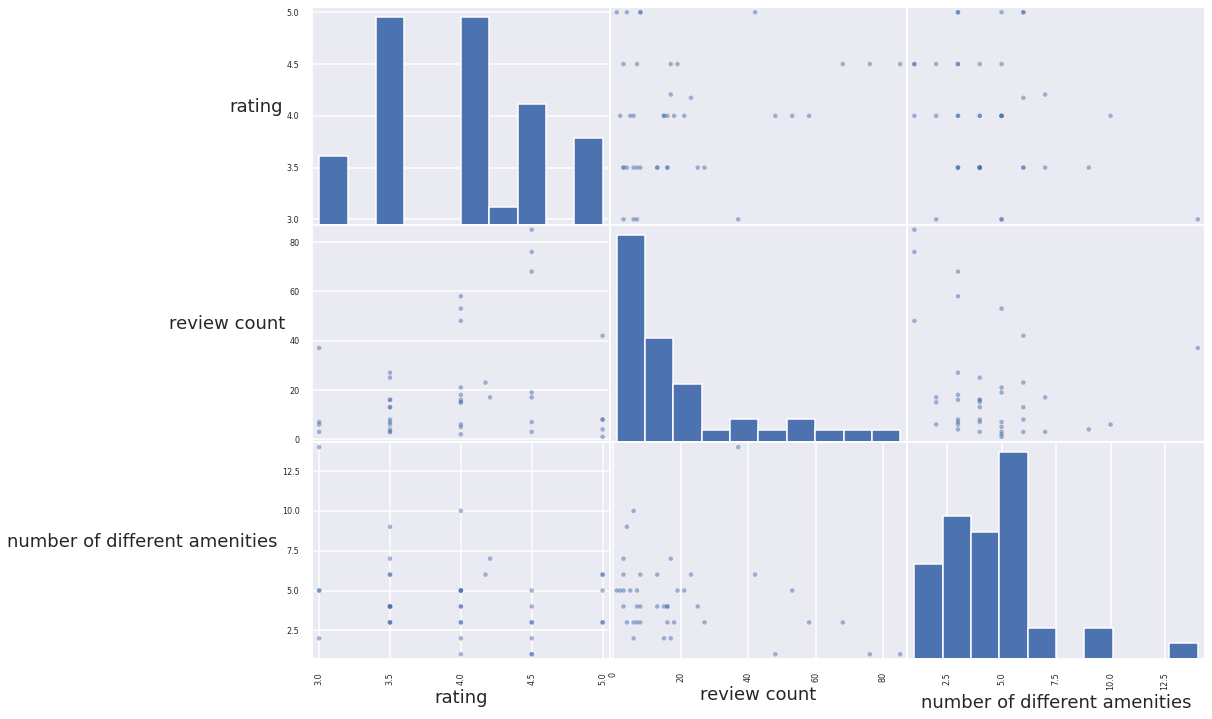

In [19]:
#scatter plot matrix for df_all
axes = pd.plotting.scatter_matrix(df_all[['rating', 'review count', 'number of different amenities']], figsize=(16, 12));

for ax in axes.flatten():
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

Figure 1: Scatter plot matrix of columns in df_all

Looking at the scatter plot matrix above, I did not notice any data values that were unreasonable.

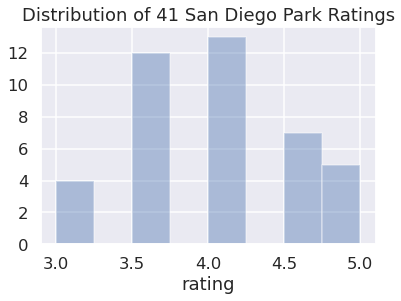

In [20]:
plot = sns.distplot(df_all['rating'], bins=8, kde=False)
plot.set_title('Distribution of 41 San Diego Park Ratings')
plt.yticks([0, 2, 4, 6, 8, 10, 12])
plt.show()

Figure 2: Yelp ratings are on a scale from 1 to 5 stars. This distribution shows that the park ratings are all between 3 and 5.

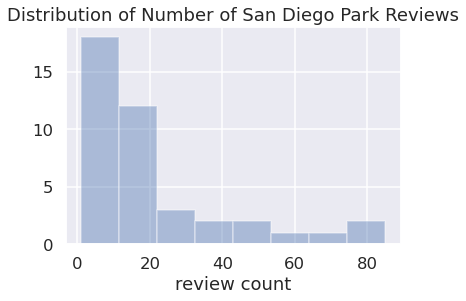

In [21]:
plot = sns.distplot(df_all['review count'], bins=8, kde=False)
plot.set_title('Distribution of Number of San Diego Park Reviews')
plt.show()

Figure 3: This distribution shows that the number of park reviews is between 0 and 85. Most San Diego parks have less than 20 Yelp reviews.

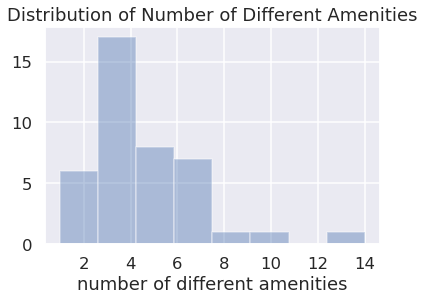

In [22]:
plot = sns.distplot(df_all['number of different amenities'], bins=8, kde=False)
plot.set_title('Distribution of Number of Different Amenities')
plt.xticks([2, 4, 6, 8, 10, 12, 14])
plt.show()

Figure 4: This distribution shows that the number of different amenities per park is between 0 and 14. Most San Diego parks have 4 or less different amenities.

Perform **ordinary least squares (OLS) regression** to find a best fit line between **rating** and **number of different amenities**.

In [23]:
#rename column for OLS model to work
df_all.rename(columns={'number of different amenities':'number_of_different_amenities'}, inplace=True)

#create OLS model and fit it
outcome, predictors = patsy.dmatrices('rating ~ number_of_different_amenities', df_all)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.581
Date:                Sat, 12 Dec 2020   Prob (F-statistic):              0.116
Time:                        13:31:12   Log-Likelihood:                -34.528
No. Observations:                  41   AIC:                             73.06
Df Residuals:                      39   BIC:                             76.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

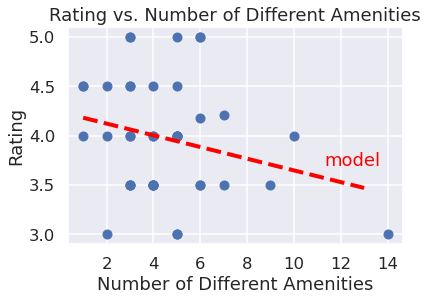

In [24]:
#create scatter plot
plt.plot('number_of_different_amenities', 'rating', 'o', data=df_all)

#plot linear regression model
x = np.arange(df_all['number_of_different_amenities'].min(), df_all['number_of_different_amenities'].max())
y = -0.0592 * x + 4.2398
plt.plot(x, y, '--', linewidth=4, color='red')

plt.title('Rating vs. Number of Different Amenities')
plt.xlabel('Number of Different Amenities')
plt.ylabel('Rating')
plt.xticks([2, 4, 6, 8, 10, 12, 14])
plt.annotate('model', xy=(11.3,3.7), xycoords='data', color='red')
plt.show()

Figure 5: This plot shows the relationship between number of different amenities per park and Yelp rating. The linear model reveals a negative correlation between the two variables—as the number of different amenities decreases, the rating decreases.

Perform **ordinary least squares (OLS) regression** to find a best fit line between **review count** and **number of different amenities**.

In [25]:
#rename column for OLS model to work
df_all.rename(columns={'review count':'review_count'}, inplace=True)

#create OLS model and fit it
outcome, predictors = patsy.dmatrices('review_count ~ number_of_different_amenities', df_all)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.020
Date:                Sat, 12 Dec 2020   Prob (F-statistic):             0.0901
Time:                        13:31:12   Log-Likelihood:                -181.56
No. Observations:                  41   AIC:                             367.1
Df Residuals:                      39   BIC:                             370.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

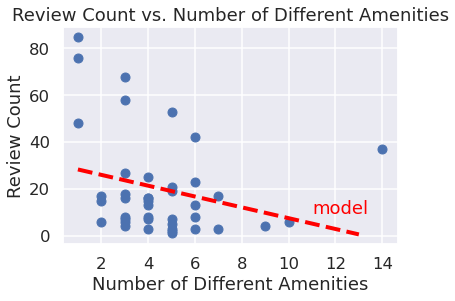

In [26]:
#create scatter plot
plt.plot('number_of_different_amenities', 'review_count', 'o', data=df_all)

#plot linear regression model
x = np.arange(df_all['number_of_different_amenities'].min(), df_all['number_of_different_amenities'].max())
y = -2.3117 * x + 30.6502
plt.plot(x, y, '--', linewidth=4, color='red')

plt.title('Review Count vs. Number of Different Amenities')
plt.xlabel('Number of Different Amenities')
plt.ylabel('Review Count')
plt.xticks([2, 4, 6, 8, 10, 12, 14])
plt.annotate('model', xy=(11,9.6), xycoords='data', color='red')
plt.show()

Figure 6: This plot shows the relationship between number of different amenities per park and review count. The linear model reveals a negative correlation between the two variables—as the number of different amenities decreases, the review count decreases.

# Ethics & Privacy

The three datasets are provided for use on the final project, so I have permission to use them for it. The links for each are provided in the Datasets section of this project, as they are public information. Since the datasets do not contain personal or harmful information, there was no need to remove any information before the analysis. Although Yelp ratings can include a person's name on Yelp, the Yelp rating dataset did not include such personal information, so there is no concern about identifying Yelp users through the dataset. On the other hand, I did not remove any identifying information for the parks, such as addresses, since they are public information.

A potential bias that I see is within the Yelp park review ratings. Since they only represent a fraction of the population that uses the parks, they are not representive of the whole. Some visitors who have an extremely positive or negative experience may be more likely to express their opinion through a review. Additionally, anyone can rate the parks, including non-visitors. These biases are unavoidable, but they should be noted to exist within the Yelp dataset.

There is also potential bias in how the park amenity data was collected and which parks contain data. There two park datasets that were analyzed were joint use parks and parks with recreation centers, so they do not represent all the San Diego parks. I do not know how each parks' amenities were tallied, but the accuracy of the two park amenity datasets are subject to the people who created the datasets. Furthermore, I do not know if all of the provided parks' amenities are considered in the datasets, and the specified ones' are subject to the dataset creators. Thus, these biases may influence the results of the data and/or analysis.

# Conclusion & Discussion

In conclusion, my hypothesis that the existence of a higher number of different amenities in parks correlates to higher park review ratings, while a lower number of different amenities in parks correlates to lower park review ratings, was incorrect. The analysis of the two variables after combining all three of the datasets revealed the opposite—a negative correlation. Additionally, my hypothesis that the existence of a higher number of different amenities in parks correlates to more park reviews, while a lower number of different amenities in parks correlates to less park reviews, was incorrect. The analysis of the two variables also revealed an opposing negative correlation.

One factor to note about my analysis is that I only analyze the effect of the number of different amenities of parks and not the amount of each amenity, so my conclusion does not describe which amenities are most significant. This is why I was able to combine some columns of the datasets, which had differing values for some amenities of the same park. The differences may be due to human error when inputting values into the dataset, or perhaps they may be due to differing time periods of the two park amenity datasets. Since the datasets were provided with no specified time period, I do not know when these park amenities were most recently updated. These time differences between the datasets is a limitation of this analysis.

Another limitation is that I rely on the amenities in the datasets to be representative of those at each park currently. They are provided by the county of San Diego, but is unknown whether the park data reflect the current status of the parks. For example, some amenities may have been replaced or added since the most recent update of the datasets. A discrepancy between the Yelp data, which was retrieved recently, and park data should be noted to be possible.

Furthermore, I combined the ratings and review counts of several parks that contain the same name. For example, I combined a 'park & recreation center' with a 'park.' I also chose to exclude the parks that were amenity-specific from the analysis. For example, I removed the ratings that were specific to dog parks and volleyball courts, since they were not ratings for the entire park. I chose to do this because the analysis focuses on number of different amenities and does not describe any specific amenity.

Lastly, a linear model is one of the many ways this data could have been analyzed. Given more time, I would have incorporated other data analysis models to describe the relationships.